# Multi-Layer Perceptron

## Libraries

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, auc, precision_recall_curve


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Data

In [3]:
data = pd.read_csv("../data/parsed_data_final.csv", index_col = [0]) 

In [4]:
data

,Gene ID,Transcript ID,Position,Nucleotide 1,Nucleotide 2,Nucleotide 3,N1 Length Avg,N1 Length Median,N1 Length Min,N1 Length Max,...,N3 Length Max,N3 SD Avg,N3 SD Median,N3 SD Min,N3 SD Max,N3 Mean Avg,N3 Mean Median,N3 Mean Min,N3 Mean Max,Label
0,ENSG00000004059,ENST00000000233,244,AAGAC,AGACC,GACCA,0.008264,0.00697,0.00199,0.0339,...,0.0329,4.386989,3.440,0.773,15.50,80.570270,80.50,73.1,88.3,0
1,ENSG00000004059,ENST00000000233,261,CAAAC,AAACT,AACTG,0.006609,0.00564,0.00199,0.0222,...,0.0262,3.016599,2.660,0.715,14.10,94.290698,94.10,88.6,103.0,0
2,ENSG00000004059,ENST00000000233,316,GAAAC,AAACA,AACAG,0.007570,0.00631,0.00232,0.0299,...,0.0266,2.087146,1.910,0.630,6.85,89.364324,89.20,84.4,96.2,0
3,ENSG00000004059,ENST00000000233,332,AGAAC,GAACA,AACAT,0.010620,0.00902,0.00232,0.0370,...,0.0214,2.236520,2.135,0.884,6.49,89.154000,89.90,81.4,95.7,0
4,ENSG00000004059,ENST00000000233,368,AGGAC,GGACA,GACAA,0.010701,0.00896,0.00199,0.0478,...,0.0485,4.260253,4.160,1.040,8.81,85.178788,85.40,77.6,90.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENSG00000167747,ENST00000641834,1348,GGGAC,GGACA,GACAT,0.009594,0.00817,0.00232,0.0432,...,0.0242,4.005616,3.640,1.030,12.50,82.004110,82.10,74.0,92.8,1
121834,ENSG00000167747,ENST00000641834,1429,CTGAC,TGACA,GACAC,0.008393,0.00618,0.00232,0.0262,...,0.0149,3.644638,3.440,1.580,6.50,80.497101,80.60,75.0,90.6,0
121835,ENSG00000167747,ENST00000641834,1531,TGGAC,GGACA,GACAC,0.008161,0.00697,0.00232,0.0315,...,0.0260,2.181562,1.925,1.040,7.19,84.190625,84.50,78.2,88.1,1
121836,ENSG00000167747,ENST00000641834,1537,CTGAC,TGACC,GACCA,0.008044,0.00660,0.00232,0.0483,...,0.0144,2.540877,2.330,1.190,6.50,82.289474,82.00,77.6,87.4,0


In [5]:
X = data.drop(columns=['Label'])
y = data['Label']
groups = data['Gene ID']

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=21)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

X_train = X_train_split.drop(columns=['Gene ID','Position','Transcript ID','Position', 'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3'])
X_test = X_test_split.drop(columns=['Gene ID','Position','Transcript ID','Position', 'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3'])


Oversampling.

In [6]:
smote = SMOTE(random_state=21)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled class distribution: {Counter(y_train_resampled)}")


Resampled class distribution: Counter({0: 79775, 1: 79775})


Normalise the features for training.

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [8]:
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train_resampled)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

## Model

In [9]:
model = Sequential()

# Input layer with 128 units and ReLU activation
model.add(Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dropout(0.3))

# Hidden layer 1 with 64 units
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Hidden layer 2 with 32 units
model.add(Dense(32, activation='relu'))

# Hidden layer 3 with 16 units
model.add(Dense(16, activation='relu'))

# Output layer (binary classification, so use sigmoid)
model.add(Dense(1, activation='sigmoid'))

/Users/arnoldlek/Desktop/DSA4262/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
input_shape = X_train_resampled.shape[1]
print(f"Input shape: {input_shape}")

Input shape: 36


### Compiling

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', 'auc'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)


### Training

In [12]:
history = model.fit(X_train_scaled, y_train, 
    validation_data=(X_test_scaled, y_test), 
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stopping])

Epoch 1/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 4s 708us/step - accuracy: 0.6817 - auc: 0.7438 - loss: 0.5870 - precision: 0.6803 - recall: 0.6991 - val_accuracy: 0.8027 - val_auc: 0.8352 - val_loss: 0.4438 - val_precision: 0.1460 - val_recall: 0.7053
Epoch 2/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 678us/step - accuracy: 0.7833 - auc: 0.8630 - loss: 0.4638 - precision: 0.7897 - recall: 0.7714 - val_accuracy: 0.8099 - val_auc: 0.8451 - val_loss: 0.4423 - val_precision: 0.1515 - val_recall: 0.7082
Epoch 3/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 648us/step - accuracy: 0.7991 - auc: 0.8796 - loss: 0.4365 - precision: 0.8058 - recall: 0.7871 - val_accuracy: 0.8174 - val_auc: 0.8496 - val_loss: 0.4258 - val_precision: 0.1585 - val_recall: 0.7170
Epoch 4/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step - accuracy: 0.8110 - auc: 0.8920 - loss: 0.4152 - precision: 0.8168 - recall: 0.8015 - val_accuracy: 0.8357 - val_auc: 0.8529 - val_loss: 0.4040 - val_precision: 0.1715 - val_recall: 0.7000
Epoch 5/50
4986/

1197/1197 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
AUC Score: 0.8607


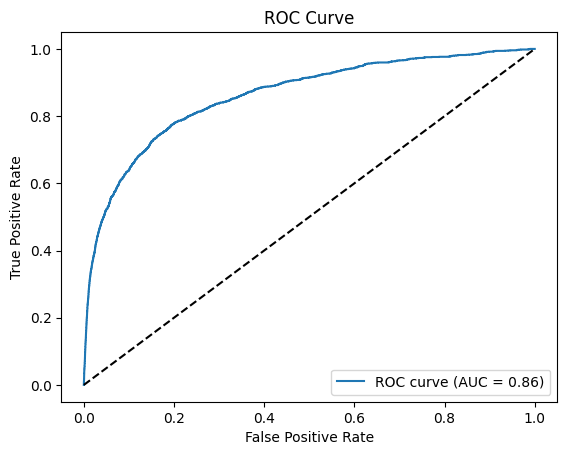

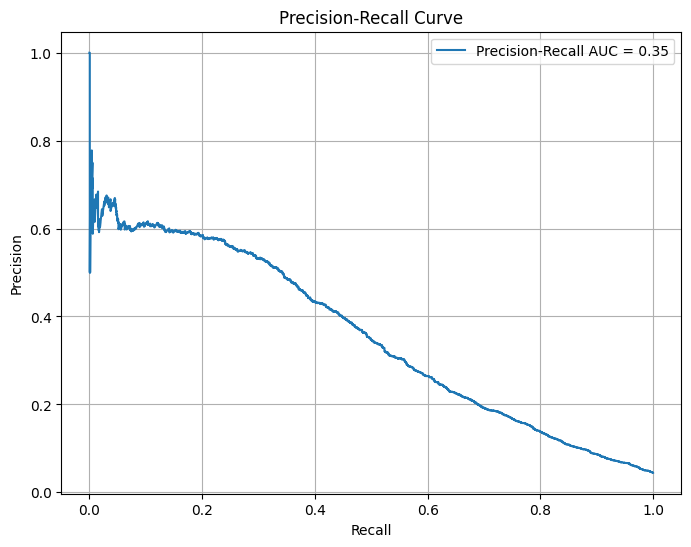

Text(0.5, 1.0, 'Confusion Matrix for QDA')

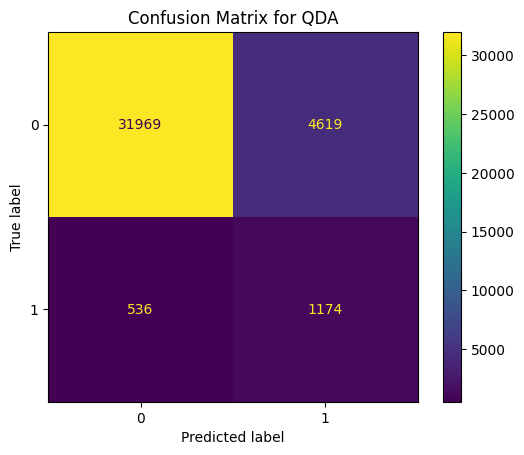

In [13]:
# Predict probabilities for the test set
y_pred_proba = model.predict(X_test_scaled)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PR-AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute the AUC for the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Confusion matrix
y_pred_class = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels
cm = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix for QDA')

### Saving the model
For future testing.

In [42]:
model.save('arnold-mlp.keras')

# FOR LOADING
# from tensorflow.keras.models import load_model

# # Load the model from the file
# model = load_model('my_model.keras')

# # Now you can use the model for predictions
# y_probs = model.predict(X_test_scaled)

## Predictions

`dataset0.json`

In [14]:
y_probs = model.predict(X_test_scaled)

results_df = X_test_split[['Transcript ID', 'Position']].copy()
results_df['Score'] = y_probs


1197/1197 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


In [15]:
results_df

,Transcript ID,Position,Score
0,ENST00000000233,244,0.082801
1,ENST00000000233,261,0.648603
2,ENST00000000233,316,0.078943
3,ENST00000000233,332,0.351711
4,ENST00000000233,368,0.088240
...,...,...,...
121732,ENST00000641375,1523,0.181592
121733,ENST00000641375,1586,0.019955
121734,ENST00000641375,1996,0.031573
121735,ENST00000641375,2022,0.000756


### Predictions Testing

In [18]:
# Code for prepping data.
def testPredictions(data):
    X = data.drop(columns=['Position','Transcript ID','Position', 'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3'])
    X_scaled = scaler.fit_transform(X)
    X_test = np.array(X_scaled)

    y_probs = model.predict(X_test)
    results_df = data[['Transcript ID', 'Position']].copy()
    results_df['Score'] = y_probs

    return results_df

`dataset1.json`

In [23]:
data1 = pd.read_csv("../data/parsed_data_1.csv", index_col = [0])
results_df_1 = testPredictions(data1)
results_df_1

2838/2838 ━━━━━━━━━━━━━━━━━━━━ 1s 298us/step


,Transcript ID,Position,Score
0,ENST00000000233,244,0.246957
1,ENST00000000233,261,0.404978
2,ENST00000000233,316,0.541934
3,ENST00000000233,332,0.410463
4,ENST00000000233,368,0.746530
...,...,...,...
90805,ENST00000641784,3122,0.626004
90806,ENST00000641784,3142,0.127986
90807,ENST00000641784,3224,0.948409
90808,ENST00000641784,3243,0.474520


`dataset2.json`

In [24]:
data2 = pd.read_csv("../data/parsed_data_2.csv", index_col = [0])
results_df_2 = testPredictions(data2)
results_df_2

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


,Transcript ID,Position,Score
0,tx_id_0,0,0.132778
1,tx_id_0,10,0.864814
2,tx_id_0,20,0.534276
3,tx_id_0,30,0.942021
4,tx_id_0,40,0.295613
...,...,...,...
1318,tx_id_6,1840,0.395974
1319,tx_id_6,1850,0.388398
1320,tx_id_6,1860,0.067940
1321,tx_id_6,1870,0.147904


### Export for Submission

In [38]:
select_0 = results_df.sample(n=2, random_state=21)
select_1 = results_df_1.sample(n=2, random_state=21)
select_2 = results_df_2.sample(n=2, random_state=21)

select_0.columns = ['transcript_id', 'transcript_position', 'score']
select_1.columns = ['transcript_id', 'transcript_position', 'score']
select_2.columns = ['transcript_id', 'transcript_position', 'score']


In [39]:
select_0.to_csv('sequenceseekers_dataset0_1.csv')
select_0

,transcript_id,transcript_position,score
27691,ENST00000278671,665,0.401468
59233,ENST00000356607,1101,0.030890


In [40]:
select_1.to_csv('sequenceseekers_dataset1_1.csv')
select_1

,transcript_id,transcript_position,score
63254,ENST00000397261,1598,0.548957
37315,ENST00000336053,932,0.426140


In [41]:
select_2.to_csv('sequenceseekers_dataset2_1.csv')
select_2

,transcript_id,transcript_position,score
573,tx_id_3,60,0.681280
1030,tx_id_5,850,0.574858
